In [4]:
import torch
import triton
import triton.language as tl


@triton.jit
def add_kernel(x_ptr,  # *Pointer* to first input vector. 指向第一个输入向量的指针。
               y_ptr,  # *Pointer* to second input vector. 指向第二个输入向量的指针。
               output_ptr,  # *Pointer* to output vector. 指向输出向量的指针。
               n_elements,  # Size of the vector. 向量的大小。
               # Number of elements each program should process. 每个程序应处理的元素数量。
               BLOCK_SIZE: tl.constexpr,
               # NOTE: `constexpr` so it can be used as a shape value. 注意：`constexpr` 因此它可以用作形状值。
               ):
    # There are multiple 'programs' processing different data. We identify which program
    # 有多个“程序”处理不同的数据。需要确定是哪一个程序：
    # We use a 1D launch grid so axis is 0. 使用 1D 启动网格，因此轴为 0。
    pid = tl.program_id(axis=0)
    # This program will process inputs that are offset from the initial data.
    # 该程序将处理相对初始数据偏移的输入。
    # For instance, if you had a vector of length 256 and block_size of 64, the programs would each access the elements [0:64, 64:128, 128:192, 192:256].
    # 例如，如果有一个长度为 256, 块大小为 64 的向量，程序将各自访问 [0:64, 64:128, 128:192, 192:256] 的元素。
    # Note that offsets is a list of pointers:
    # 注意 offsets 是指针列表：
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    # Create a mask to guard memory operations against out-of-bounds accesses.
    # 创建掩码以防止内存操作超出边界访问。
    mask = offsets < n_elements
    # Load x and y from DRAM, masking out any extra elements in case the input is not a multiple of the block size.
    # 从 DRAM 加载 x 和 y，如果输入不是块大小的整数倍，则屏蔽掉任何多余的元素。
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    # Write x + y back to DRAM.
    # 将 x + y 写回 DRAM。
    tl.store(output_ptr + offsets, output, mask=mask)

def add(x: torch.Tensor, y: torch.Tensor):
    # We need to preallocate the output.
    # 需要预分配输出。
    output = torch.empty_like(x)
    assert x.is_cuda and y.is_cuda and output.is_cuda
    n_elements = output.numel()
    # The SPMD launch grid denotes the number of kernel instances that run in parallel.
    # SPMD 启动网格表示并行运行的内核实例的数量。
    # It is analogous to CUDA launch grids. It can be either Tuple[int], or Callable(metaparameters) -> Tuple[int].
    # 它类似于 CUDA 启动网格。它可以是 Tuple[int]，也可以是 Callable(metaparameters) -> Tuple[int]。
    # In this case, we use a 1D grid where the size is the number of blocks:
    # 在这种情况下，使用 1D 网格，其中大小是块的数量：
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    # NOTE:
    # 注意：
    #  - Each torch.tensor object is implicitly converted into a pointer to its first element.
    #  - 每个 torch.tensor 对象都会隐式转换为其第一个元素的指针。
    #  - `triton.jit`'ed functions can be indexed with a launch grid to obtain a callable GPU kernel.
    #  - `triton.jit` 函数可以通过启动网格索引来获得可调用的 GPU 内核。
    #  - Don't forget to pass meta-parameters as keywords arguments.
    #  - 不要忘记以关键字参数传递元参数。
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    # We return a handle to z but, since `torch.cuda.synchronize()` hasn't been called, the kernel is still running asynchronously at this point.
    # 返回 z 的句柄，但由于 `torch.cuda.synchronize()` 尚未被调用，此时内核仍在异步运行。
    return output


In [ ]:
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device='cuda')
y = torch.rand(size, device='cuda')
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([1.3713, 1.3076, 0.4940,  ..., 0.9592, 0.3409, 1.2567], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.9592, 0.3409, 1.2567], device='cuda:0')
The maximum difference between torch and triton is 0.0


In [6]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        # Argument names to use as an x-axis for the plot. 用作绘图 x 轴的参数名称。
        x_names=['size'],
        # Different possible values for `x_name`. `x_name` 的不同可能值。
        x_vals=[2**i for i in range(12, 28, 1)],
        x_log=True,  # x axis is logarithmic. x 轴为对数。
        # Argument name whose value corresponds to a different line in the plot. 参数名称，其值对应于绘图中的不同线条。
        line_arg='provider',
        # Possible values for `line_arg`. `line_arg` 的可能值。
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],  # Label name for the lines. 线条的标签名称。
        styles=[('blue', '-'), ('green', '-')],  # Line styles. 线条样式。
        ylabel='GB/s',  # Label name for the y-axis. y 轴标签名称。
        # Name for the plot. Used also as a file name for saving the plot. 绘图名称。也用作保存绘图的文件名。
        plot_name='vector-add-performance',
        args={},  # Values for function arguments not in `x_names` and `y_name`. 不在 `x_names` 和 `y_name` 中的函数参数值。
    ))
def benchmark(size, provider):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    y = torch.rand(size, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: add(x, y), quantiles=quantiles)

    def gbps(ms): return 3 * x.numel() * x.element_size() / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

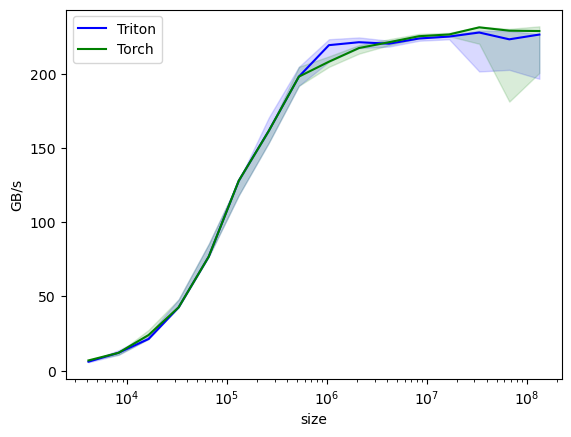

vector-add-performance:
           size      Triton       Torch
0        4096.0    6.000000    6.857143
1        8192.0   12.000000   12.000000
2       16384.0   21.333333   24.000000
3       32768.0   42.666665   42.666665
4       65536.0   76.800002   76.800002
5      131072.0  127.999995  127.999995
6      262144.0  161.684218  161.684218
7      524288.0  198.193551  198.193551
8     1048576.0  219.428568  208.271180
9     2097152.0  221.405403  217.486722
10    4194304.0  220.412561  221.405403
11    8388608.0  223.927109  225.467889
12   16777216.0  225.209619  226.637472
13   33554432.0  227.951307  231.439668
14   67108864.0  223.354727  229.180246
15  134217728.0  226.572177  228.946720


In [ ]:
benchmark.run(print_data=True, show_plots=True)